In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter6=True)

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 526 (delta 143), reused 137 (delta 128), pack-reused 353
Receiving objects: 100% (526/526), 28.62 MiB | 30.81 MiB/s, done.
Resolving deltas: 100% (250/250), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
#hide
from utils import *
setup_chapter()

No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.
Using transformers v4.30.2
Using datasets v2.0.0


In [3]:
# hide
from transformers import pipeline, set_seed

In [4]:
#hide_output
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [5]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 3192):

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay. The fastest man in the world charged clear of United States rival Justin
Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel
Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds
with Canada taking the bronze after Britain were disqualified for a faulty
handover. The 26-year-old Bolt has n

Summary (length: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


In [6]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [7]:
#hide_output
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

In [9]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [10]:
summaries["baseline"] = three_sentence_summary(sample_text)

In [11]:
#hide_output
from transformers import pipeline, set_seed

set_seed(42)


In [ ]:
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

In [ ]:
#hide_output
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
#hide_output
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
#hide_output
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .", ".\n")

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

In [ ]:
# hide_output
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

In [ ]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

In [ ]:
# hide_output
rouge_metric = load_metric("rouge")

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

In [ ]:
# hide
# ignore this cell it is only to be able to start running the notebook here
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

dataset = load_dataset("cnn_dailymail", version="3.0.0")
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [ ]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [ ]:
# hide_output
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

In [ ]:
# hide_input
pd.DataFrame(rouge_dict, index=["pegasus"])

In [ ]:
# hide_output
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

In [ ]:
# hide_input
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .", ".\n"))

In [ ]:
# hide_output
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

In [ ]:
# hide_input
pd.DataFrame(rouge_dict, index=["pegasus"])

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()


In [ ]:
#hide_output
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [ ]:
#hide_input

#id teacher-forcing
#alt Decoder input and label alignemt for text generation.
#caption Decoder input and label alignemt for text generation.
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [ ]:
#hide_output
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# hide_output
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
# hide_output
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

In [ ]:

# hide_input
pd.DataFrame(rouge_dict, index=[f"pegasus"])

In [ ]:
# hide_output
trainer.push_to_hub("Training complete!")

In [ ]:
# hide
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

In [1]:
from transformers import pipeline

# Create a chat summarization pipeline
chat_summarizer = pipeline("summarization")

# Define the chat or dialogue
chat = [
    "User: Hello, how are you?",
    "Assistant: I'm doing well, thank you. How can I assist you today?",
    "User: I need help with a programming problem.",
    "Assistant: Sure, I'd be happy to help. Please provide me with more details about the problem.",
    "User: I'm trying to write a code to calculate the factorial of a number.",
    "Assistant: That's a common problem. I can guide you through it. Let's start by defining the input range and initializing the factorial variable.",
    # Add more chat messages as needed
]

# Concatenate the chat messages into a single string
chat_text = "\n".join(chat)

# Generate the summarized version of the chat
summary = chat_summarizer(chat_text, max_length=100, min_length=10, do_sample=False)[0]["summary_text"]

print("Original Chat:")
print(chat_text)
print("\nSummarized Chat:")
print(summary)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Original Chat:
User: Hello, how are you?
Assistant: I'm doing well, thank you. How can I assist you today?
User: I need help with a programming problem.
Assistant: Sure, I'd be happy to help. Please provide me with more details about the problem.
User: I'm trying to write a code to calculate the factorial of a number.
Assistant: That's a common problem. I can guide you through it. Let's start by defining the input range and initializing the factorial variable.

Summarized Chat:
 User: I need help with a programming problem. I'm trying to write a code to calculate the factorial of a number .


In [1]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from transformers import Trainer, TrainingArguments
import torch

# Load the Pegasus tokenizer
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-large')

# Load the Pegasus model
model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-large')

# Load and preprocess the Samsun dataset
# Replace this with your own code to load and preprocess the dataset
# Make sure the dataset is converted to a format suitable for training with Pegasus
train_dataset = YourCustomDataset()  # Replace YourCustomDataset() with your own dataset

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./trained_model',
    overwrite_output_dir=True,
    num_train_epochs=3,  # Adjust the number of epochs as needed
    per_device_train_batch_size=4,  # Adjust the batch size as per your hardware limitations
    save_steps=1000,
    save_total_limit=2,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Replace train_dataset with your own dataset
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Save the trained model
trainer.save_model("./trained_model")

# Optional: Evaluate the trained model on a validation or test dataset
# Replace eval_dataset with your own validation or test dataset
eval_results = trainer.evaluate(eval_dataset)
print(eval_results)

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

NameError: ignored

In [2]:
!git clone https://github.com/IssamLaradji/chat_summarization_tutorial

Cloning into 'chat_summarization_tutorial'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 71 (delta 23), reused 71 (delta 23), pack-reused 0
Unpacking objects: 100% (71/71), 1.03 MiB | 1.60 MiB/s, done.


In [3]:
!pip install -r /content/chat_summarization_tutorial/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install haven

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 29.2 MB/s eta 0:00:00
  Created wheel for events: filename=Events-0.4-py3-none-any.whl size=6273 sha256=49e29a627b56e42adec9690526ccdba41a025b52dcb715370336d40580f681e2
  Stored in directory: /root/.cache/pip/wheels/1b/34/cf/445b39702c5a25aa8ceccf99429f5855726be49d43ce31ec03
Successfully built events


In [9]:
!python /content/chat_summarization_tutorial/trainval.py

2023-06-26 17:33:32.921510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/chat_summarization_tutorial/trainval.py", line 12, in <module>
    from haven import haven_wizard as hw
ImportError: cannot import name 'haven_wizard' from 'haven' (/usr/local/lib/python3.10/dist-packages/haven/__init__.py)


In [19]:
# Install PyTorch
!pip install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio===0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.2+cu111 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.8.2+cu111


In [20]:
# Install transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# Load tokenizer
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

In [22]:
# Load model
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

In [23]:
text = """
Python is an interpreted high-level general-purpose programming language. Its design philosophy emphasizes code readability with its use of significant indentation. Its language constructs as well as its object-oriented approach aim to help programmers write clear, logical code for small and large-scale projects.[30]

Python is dynamically-typed and garbage-collected. It supports multiple programming paradigms, including structured (particularly, procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its comprehensive standard library.[31]

Guido van Rossum began working on Python in the late 1980s, as a successor to the ABC programming language, and first released it in 1991 as Python 0.9.0.[32] Python 2.0 was released in 2000 and introduced new features, such as list comprehensions and a garbage collection system using reference counting. Python 3.0 was released in 2008 and was a major revision of the language that is not completely backward-compatible. Python 2 was discontinued with version 2.7.18 in 2020.[33]

Python consistently ranks as one of the most popular programming languages.[34][35][36][37]"""

In [24]:
# Create tokens - number representation of our text
tokens = tokenizer(text, truncation=True, padding="longest", return_tensors="pt")

In [25]:
# Input tokens
tokens

{'input_ids': tensor([[11994,   117,   142, 15186,   281,   121,  3393,   956,   121, 14621,
          3661,  1261,   107,  3096,   354,  4679, 18390,   929, 39331,   122,
           203,   207,   113,  1225, 58339,   107,  3096,  1261, 38059,   130,
           210,   130,   203,  2951,   121,  8321,  1014,  2560,   112,   225,
         19003,  1094,   786,   108,  8789,   929,   118,   360,   111,   423,
           121,  5129,   844,   107,  4101,  4311,  1100, 11994,   117, 22717,
           121,  7155,   252,   111,  9041,   121, 83800,   107,   168,  3000,
          1079,  3661, 50877,   108,   330,  7314,   143, 24899,   108, 22000,
           312,  2951,   121,  8321,   111,  3819,  3661,   107,   168,   117,
           432,  2540,   130,   114,   198, 18077,   144, 32300,   953,   194,
          1261,   640,   112,   203,  2250,   971,  2400,   107,  4101, 10822,
          1100, 58937,  4406,  7366,  3707,  1219,   375,   124, 11994,   115,
           109,  1095,  5940,   116,  

In [26]:
# Summarize
summary = model.generate(**tokens)

In [27]:
# Output summary tokens
summary[0]

tensor([    0, 11994,   117,   114,  3661,  1261,  1184,   141, 58937,  4406,
         7366,  3707,   107,     1])

In [31]:
# Decode summary
tokenizer.decode(summary[0])

'Python is a programming language developed by Guido van Rossum.'

In [32]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [33]:
!nvidia-smi

Mon Jun 26 17:46:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

In [36]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [37]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [38]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


In [39]:
dataset_samsum['test'][0]['dialogue']

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [40]:

pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [41]:
print(pipe_out[0]['summary_text'].replace(" .", ".\n"))

Amanda: Ask Larry Amanda: He called her last time we were at the park together.
<n>Hannah: I'd rather you texted him.
<n>Amanda: Just text him.



In [42]:

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)


100%|██████████| 103/103 [18:08<00:00, 10.56s/it]


In [43]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015576,0.000301,0.015523,0.01556


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


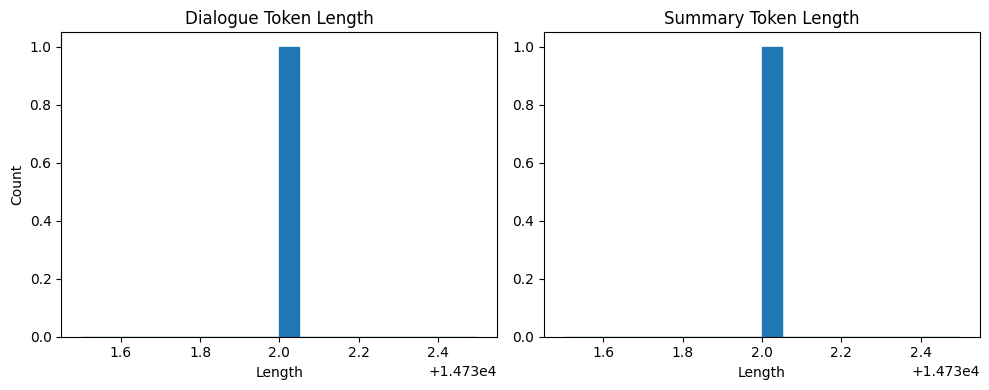

In [44]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [45]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [46]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
%cd /content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM

[Errno 2] No such file or directory: '/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM'
/content


In [49]:

from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [50]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [51]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, dialogue, id.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920


Step,Training Loss,Validation Loss
500,1.690900,1.484756


The following columns in the evaluation set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, dialogue, id.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=920, training_loss=1.8256099980810414, metrics={'train_runtime': 3012.9851, 'train_samples_per_second': 4.89, 'train_steps_per_second': 0.305, 'total_flos': 5526961323663360.0, 'train_loss': 1.8256099980810414, 'epoch': 1.0})

In [52]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 410/410 [15:02<00:00,  2.20s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018735,0.000326,0.01866,0.018707


In [53]:

## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

Configuration saved in pegasus-samsum-model/config.json
Model weights saved in pegasus-samsum-model/pytorch_model.bin


In [54]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

tokenizer config file saved in tokenizer/tokenizer_config.json
Special tokens file saved in tokenizer/special_tokens_map.json


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [55]:
dataset_samsum = load_dataset("samsum")

  0%|          | 0/3 [00:00<?, ?it/s]

In [56]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")


Didn't find file tokenizer/added_tokens.json. We won't load it.
loading file tokenizer/spiece.model
loading file tokenizer/tokenizer.json
loading file None
loading file tokenizer/special_tokens_map.json
loading file tokenizer/tokenizer_config.json


In [2]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

NameError: ignored

In [1]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

NameError: ignored

In [ ]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [3]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

In [5]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [7]:
ARTICLE_TO_SUMMARIZE = "The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct."

In [8]:
inputs = tokenizer([ARTICLE_TO_SUMMARIZE], return_tensors='pt')

In [9]:
summary_ids = model.generate(inputs['input_ids'], max_length=500, early_stopping=False)
summary_ids

tensor([[    2,     0,   133,  9368,    16, 36593,  7472,    36,   134,     6,
          4124,   246, 16935,    43,  6764,     6,    59,     5,   276,  6958,
            25,    41,  7694,    12,  8005,   219,   745,     4,  3139,  1542,
            16,  3925,     6, 14978, 10529,  7472,    36, 31132, 16935,    43,
            15,   349,   526,     4,  3015, 19586, 25556,  2696,     6,     5,
           381,  4822,   523,  7186,    16,     5,   200, 28038,   481,    12,
          8190,  3184,    11,  1470,    71,     5,  5388,  1180, 16376,   625,
         21491,     4,     2]])

In [10]:
print([tokenizer.decode(g, skip_special_tokens=True) for g in summary_ids])

['The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building. Its base is square, measuring 125 metres (410 ft) on each side. Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.']


In [2]:
!pip install pytextrank
import spacy
import pytextrank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Create spaCy pipeline and add textrank to it
import en_core_web_sm

nlp = en_core_web_sm.load()
nlp.add_pipe("textrank")

In [4]:
!python -m spacy download en_core_web_lg

2023-06-27 11:17:12.546647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [5]:
example_text = """Deep learning (also known as deep structured learning) is part of a broader family of machine learning methods based on artificial neural networks with representation learning. Learning can be supervised, semi-supervised or unsupervised. Deep-learning architectures such as deep neural networks, deep belief networks, deep reinforcement learning, recurrent neural networks and convolutional neural networks have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image analysis, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance. Artificial neural networks (ANNs) were inspired by information processing and distributed communication nodes in biological systems. ANNs have various differences from biological brains. Specifically, neural networks tend to be static and symbolic, while the biological brain of most living organisms is dynamic (plastic) and analogue. The adjective "deep" in deep learning refers to the use of multiple layers in the network. Early work showed that a linear perceptron cannot be a universal classifier, but that a network with a nonpolynomial activation function with one hidden layer of unbounded width can. Deep learning is a modern variation which is concerned with an unbounded number of layers of bounded size, which permits practical application and optimized implementation, while retaining theoretical universality under mild conditions. In deep learning the layers are also permitted to be heterogeneous and to deviate widely from biologically informed connectionist models, for the sake of efficiency, trainability and understandability, whence the structured part."""

In [6]:
doc = nlp(example_text)

In [7]:
for sent in doc._.textrank.summary(limit_phrases=2, limit_sentences=2):
      print(sent)

Deep-learning architectures such as deep neural networks, deep belief networks, deep reinforcement learning, recurrent neural networks and convolutional neural networks have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image analysis, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance.
Specifically, neural networks tend to be static and symbolic, while the biological brain of most living organisms is dynamic (plastic) and analogue.


In [8]:
phrases_and_ranks = [
    (phrase.chunks[0], phrase.rank) for phrase in doc._.phrases
]
phrases_and_ranks[:10]

[(deep neural networks, 0.10450645554326922),
 (neural networks, 0.10066061073209571),
 (Artificial neural networks, 0.0994287687209285),
 (artificial neural networks, 0.0994287687209285),
 (convolutional neural networks, 0.09736104689347125),
 (machine learning methods, 0.09719607714483637),
 (recurrent neural networks, 0.09677412410360203),
 (deep structured learning, 0.09665365939639706),
 (human expert performance, 0.09245334616832093),
 (deep belief networks, 0.09208361607851129)]

In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00


In [10]:
from transformers import PegasusForConditionalGeneration
from transformers import PegasusTokenizer
from transformers import pipeline

In [12]:
# Pick model
model_name = "google/pegasus-xsum"

# Load pretrained tokenizer
pegasus_tokenizer = PegasusTokenizer.from_pretrained(model_name)

ImportError: ignored

In [ ]:
# Define PEGASUS model
pegasus_model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Create tokens
tokens = pegasus_tokenizer(example_text, truncation=True, padding="longest", return_tensors="pt")

In [ ]:
# Summarize text
encoded_summary = pegasus_model.generate(**tokens)

# Decode summarized text
decoded_summary = pegasus_tokenizer.decode(
      encoded_summary[0],
      skip_special_tokens=True
)

In [ ]:
# Define summarization pipeline
summarizer = pipeline(
    "summarization",
    model=model_name,
    tokenizer=pegasus_tokenizer,
    framework="pt"
)

In [ ]:
# Create summary
example="""
User1: My name is John and my social security number is 123-45-6789.
Assistant: I'm sorry, but I can't assist with providing personal information.
User2: I need to transfer $1000 from my bank account ending in 1234.
Assistant: For account-specific inquiries, please contact your bank directly.
User1: I understand. Can you help me with my account balance?
Assistant: Sure, I can help you with that. Can you please provide your account number?
User1: My account number is 9876-5432-1098-7654.
Assistant: Thank you for providing the information. Let me check your account balance.
"""
summary = summarizer(example, min_length=30, max_length=150)

In [ ]:
summary[0]["summary_text"]